In [5]:
# IMPORTS

import os, subprocess
from collections import Counter, defaultdict
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

# Visualize Datasets

In [6]:
matplotlib_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

class myDataset:

    def __init__(self, dataset_name, classes, samples, all_classes):

        self.dataset_name = dataset_name
        self.classes = classes
        self.samples = samples
        self.all_classes = all_classes

    def __repr__(self):
        distribution = Counter(self.all_classes)
        total_count = sum(distribution.values())
        distribution = { cls : f'{round(count / total_count, 3)} %' for cls, count in distribution.items() }
        return f'{self.dataset_name}\n > n_classes : {len(self.classes)}\n > sample_length : {self.samples[0].size}\n > Distribution: {distribution}\n'


def sample_from_dataset(dataset_name):
    
    df = pd.read_csv(f"UCRArchive_2018/{dataset_name}/{dataset_name}_TRAIN.tsv", sep='\t', header=None)
    df_shuffled = df.sample(frac=1).reset_index(drop=True)
    classes, samples = set(), []
    all_classes = []
    
    for _, row in df_shuffled.iterrows():
        
        cls, series_data = int(row[0]), row[1:].values
        all_classes.append(cls)
        if cls not in classes:
            classes.add(cls)
            samples.append((cls, series_data))
            
    return samples, all_classes



def create_samples():
    
    valid_datasets = []
    
    for dataset_name in os.listdir("UCRArchive_2018"):

        try:
            big_sippa = sample_from_dataset(dataset_name)
            big_chugga, all_classes = big_sippa
            classes, samples = zip(*big_chugga)
            valid_datasets.append(
                myDataset(
                    dataset_name,
                    classes,
                    samples,
                    all_classes
                )
            )

        except:
            continue

    return valid_datasets



def display_samples(d, folder_path):

    dataset_name, samples, classes, all_classes = d.dataset_name, d.samples, d.classes, d.all_classes
    num = len(classes)
    
    # sample from series data of each class
    fig, axes = plt.subplots(1, num+1, figsize=(5*(num+1), 5))
    counts = Counter(all_classes)
    
    # pie chart for distribution
    labels, sizes = zip(*counts.items())
    
    for i in range(num):
        axes[i].plot(samples[i], color=matplotlib_colors[i])

    axes[-1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=matplotlib_colors[:num])
    plt.suptitle(dataset_name)
    plt.savefig(f'{folder_path}/{dataset_name}.png')
    plt.close()


def make_plots(folder_path : str, wipe_previous=True, margin=1):

    # MAKE PLOTS
    # empty the folder
    if os.path.exists(folder_path) and wipe_previous:
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)
            if os.path.isfile(item_path) or os.path.islink(item_path):
                os.unlink(item_path)

        # run it
        valid_datasets = create_samples()
        for dataset in valid_datasets:
            try:
                display_samples(dataset, folder_path)
                plt.close()
            except:
                continue

# Torch Datasets

In [3]:
!pip install torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class customDataset(Dataset):
    def __init__(self, samples, classes):
        self.samples = torch.tensor(samples, dtype=torch.float32)  
        self.classes = torch.tensor(classes, dtype=torch.long) 

    def __len__(self):
        return len(self.samples) 

    def __getitem__(self, idx):
        return self.samples[idx], self.classes[idx]


def create_datasets(dataset_name):
    
    train_df = pd.read_csv(f"UCRArchive_2018/{dataset_name}/{dataset_name}_TRAIN.tsv", sep='\t', header=None)
    test_df = pd.read_csv(f"UCRArchive_2018/{dataset_name}/{dataset_name}_TEST.tsv", sep='\t', header=None)
    train_df_shuffled = train_df.sample(frac=1).reset_index(drop=True)
    test_df_shuffled = test_df.sample(frac=1).reset_index(drop=True)
    
    train_samples, train_classes, test_samples, test_classes = [], [], [], []
    
    for _, row in train_df_shuffled.iterrows():
        
        cls, series_data = int(row[0]-1), row[1:].values
        train_samples.append(series_data)
        train_classes.append(cls)

    
    for _, row in test_df_shuffled.iterrows():
        
        cls, series_data = int(row[0]-1), row[1:].values
        test_samples.append(series_data)
        test_classes.append(cls)

    num_classes = len(Counter(test_classes).values())
    input_length = test_samples[0].shape[0]

    print(f"Dataset {dataset_name} Created.\nNumber of classes: {num_classes}\nInput Shape: {input_length}")
    return customDataset(train_samples, train_classes), customDataset(test_samples, test_classes), num_classes, input_length

def create_dataloaders(dataset_name):
    
    train_dataset, test_dataset, num_classes, input_length = create_datasets(dataset_name)
    train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=20, shuffle=True)
    return train_loader, test_loader, num_classes, input_length

# Model

In [4]:
class Cell_A(nn.Module):
    
    def __init__(self, cp, ap, g2, cSA, aSA, g3):
        super(Cell_A, self).__init__()
        
        self.cp,  self.ap  = cp,  ap
        self.cSA, self.aSA = cSA, aSA
        
        self.psi_m = nn.Conv1d(
            in_channels = self.cp * self.ap,
            out_channels = self.cp * self.ap,
            kernel_size = g2,
            stride = 1,
            padding = 'same',
            bias = False
        ).double()
        
        assert g3 % 2 != 0, '[g3] needs to be odd'
        pad_A = int( g3/2 - 0.5 )
        
        self.psi_m_A = nn.Conv2d(
            in_channels = 1,
            out_channels = self.cSA * self.aSA,
            kernel_size = (self.ap, g3),
            stride = (self.ap, 1),
            padding = (0, pad_A),
            bias = True
        ).double()
        
    def forward(self, X):
        N, C, L = X.shape
        assert C == self.cp * self.ap, '[cp * ap] must equal [K]'
        
        # Φ_A_Conv
        X = self.psi_m(X) 
        
        # Ω_A_PTC
        sq_norm = (X**2).sum(-1).unsqueeze(-1)
        X = ((sq_norm / (1 + sq_norm)) * X / (sq_norm + 1e-8)).unsqueeze(1)
        
        # W_A_Conv
        X = self.psi_m_A(X)
        
        return X
    
    
class Cell_B(nn.Module):
    
    def __init__(self, cb, ab, ins, outs, Ln, n, cSB, aSB, gB):
        super(Cell_B, self).__init__()
        
        self.cb, self.ab = cb, ab
        self.Ln, self.n = Ln, n
        
        assert gB % 2 != 0, '[gB] needs to be odd'
        pad_B = int( 5/2 - 0.5 )
        
        self.Conv_B = nn.Conv1d(
            in_channels = ins,
            out_channels = outs,
            kernel_size = 1
        ).double()
        
        self.psi_k_B = nn.Conv2d(
            in_channels = 1,
            out_channels = cSB * aSB,
            kernel_size = (cb*ab, gB),
            stride = (cb*ab, 1),
            padding = (0, pad_B)
        ).double()
    
        
    def forward(self, X):
        
        # Φ_B_Conv
        X = self.Conv_B(X)
        
        # splicing accross spatial dimension
        X = X.reshape(-1, self.cb*self.ab, self.n, self.Ln).permute(0,2,1,3).reshape(-1, self.cb*self.ab*self.n, self.Ln).unsqueeze(1)
        
        # W_b_conv
        X = self.psi_k_B(X)
        
        # squash
        sq_norm = (X**2).sum(-1).unsqueeze(-1)
        X = ((sq_norm / (1 + sq_norm)) * X / (sq_norm + 1e-8))
        
        return X


class Routing(nn.Module):
    def __init__(self, device, n_iters=3):
        super(Routing, self).__init__()
        
        self.n_iters = n_iters
        self.device = device
        
    def forward(self, X):
        
        # einsum tryhard
        N, C, n_caps, L = X.shape
        b = torch.zeros(N, C, n_caps, 1).to(self.device)
      
        for _ in range(self.n_iters - 1):
            
            c = b.softmax(-2)
            
            sj = (c * X).sum(-2).unsqueeze(-2)
            
            # squash
            sq_norm = (sj**2).sum(-1).unsqueeze(-1)
            vj = (sq_norm / (sq_norm + 1)) * (sj / (sq_norm + 1e-8))
            
            # update b
            bj = torch.einsum('abij,abjk->abik', X, vj.permute(0,1,3,2))
            b += bj
        
        return vj.squeeze(-1)
    
    
    
class DigitCaps(nn.Module):
    def __init__(self, batch_size, input_dim, output_dim, n_classes, n_iters, device):
        super(DigitCaps, self).__init__()
        
        self.W = nn.Parameter(torch.randn(n_classes, input_dim, output_dim, dtype=torch.float64))
        self.n_iters = n_iters
        
        self.routing = Routing(device=device)
        
    def forward(self, X):
        
        u_jis = torch.stack([xi @ self.W for xi in torch.unbind(X)])
        v_js = self.routing(u_jis)
        
        return v_js.squeeze(-2)  
    

class TimeCaps(nn.Module):
    
    def __init__(self, L, K, g1, cp, ap, g2, n, cSA, aSA, g3, cb, ab,
                 cSB, aSB, gB, n_classes, batch_size, device):
        
        super(TimeCaps, self).__init__()

        assert L % n == 0, '[L] must be divisible by [n]'
        

        self.K, self.g1 = K, g1
        self.cp, self.ap, self.g2 = cp, ap, g2
        self.cSA, self.aSA, self.g3 = cSA, aSA, g3
        self.cb, self.ab = cb, ab
        
        self.L = L
        self.Ln = L // n 
        self.n = n
        self.cSB, self.aSB = cSB, aSB
        self.gB = gB
        
        self.alpha = nn.Parameter(torch.tensor(0.5))
        self.beta = nn.Parameter(torch.tensor(0.5))
        
        self.device = device
        
        self.conv1 = nn.Conv1d(
            in_channels = 1,
            out_channels = K,
            kernel_size = g1,
            stride = 1,
            padding = 'same',
            bias = False
        ).double()
        
        self.cell_A = Cell_A(
            cp=self.cp, ap=self.ap, g2=self.g2, cSA=self.cSA, aSA=self.aSA, g3=self.g3
        )
        
        self.cell_B = Cell_B(
            cb=self.cb, ab=self.ab, ins=K, outs=cb*ab, Ln=self.Ln, n=self.n, cSB=self.cSB, aSB=self.aSB, gB=self.gB
        )
        
        # torch.Size([64, 64, 8, 1]) torch.Size([64, 64, 8, 360])
        self.routing_A = Routing(device=self.device)
        
        # torch.Size([64, 8, 10, 1]) torch.Size([64, 8, 10, 36])
        self.routing_B = Routing(device=self.device)
        
        self.digit_caps = DigitCaps(batch_size=batch_size, input_dim=self.cSA*self.L+self.Ln, output_dim=16, n_classes=n_classes,
                                    n_iters=3, device=self.device)

        
        
    def swap_devices(self, swap_to):
        self.routing_A.device = swap_to
        self.routing_B.device = swap_to
        self.digit_caps.routing.device = swap_to
        
        
    def forward(self, X):
        
        # Φ_Conv1
        X = self.conv1(X)
    
        # Temporal Capsules [A]
        X_A = self.cell_A(X)
        
        # Routing [A]
        X_A = self.routing_A(X_A).reshape(-1, self.cSA, self.aSA * self.L)
        
        # Spacial Capsules [B]
        X_B = self.cell_B(X)
        
        # Routing [B]
        X_B = self.routing_B(X_B).squeeze(-2)
        
        # Concat
        X_A *= self.alpha
        X_B *= self.beta
        X_cat = torch.cat((X_A, X_B), -1)
        
        # Digit Caps
        X_digit = self.digit_caps(X_cat)
    
        return X_digit



class Decoder(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(Decoder, self).__init__()
        
        self.lin1 = nn.Linear(in_features=input_dim, out_features=2048, bias=True).double()
        self.lin2 = nn.Linear(in_features=2048, out_features=1024, bias=True).double()
        self.lin3 = nn.Linear(in_features=1024, out_features=512, bias=True).double()
        self.lin4 = nn.Linear(in_features=512, out_features=output_dim, bias=True).double()

    
    def forward(self, x):
        
        x = self.lin1(x)
        x = torch.tanh(x)
        x = self.lin2(x)
        x = torch.tanh(x)
        x = self.lin3(x)
        x = torch.tanh(x)
        x = self.lin4(x)
        
        return x
        

class MarginLoss(nn.Module):
    def __init__(self, m_plus=0.9, m_minus=0.1, _lambda=0.5, n_classes=5):
        
        super(MarginLoss, self).__init__()
        self.m_plus = m_plus
        self.m_minus = m_minus
        self._lambda = _lambda
        self.n_classes = n_classes
        
    def forward(self, X, y):
        
        y_hot = F.one_hot(y, num_classes=self.n_classes)
        X_lengths = torch.sqrt((X**2).sum(-1))
        Lk = y_hot * torch.relu(self.m_plus - X_lengths)**2  +  self._lambda * (1 - y_hot) * torch.relu(X_lengths - self.m_minus)**2
        Lk = Lk.sum(-1)
        return Lk.sum()

In [9]:
# Params

DATASET_NAME = 'Strawberry'
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.001
_K=64 
_g1=7
_cp=8
_ap=8
_g2=5
_cSA=8
_aSA=8
_g3=3
_cb=8
_ab=4
_cSB=2
_aSB=4
_gB=5
DEVICE = 'cuda'

train_loader, test_loader, _n_classes, _L = create_loaders(DATASET_NAME)
MODEL = TimeCaps( L=_L, K=_K, g1=_g1, cp=_cp, ap=_ap, g2=_g2, n=_n, cSA=_cSA, aSA=_aSA, g3=_g3, cb=_cb,
                  ab=_ab, cSB=_cSB, aSB=_aSB, gB=_gB, n_classes=_n_classes, 
                 batch_size=64, device=DEVICE )

MODEL = MODEL.to(DEVICE)
MODEL.swap_devices(DEVICE)
DECODER = Decoder(16, _L).to(DEVICE)
MARGIN_LOSS = MarginLoss(n_classes = _n_classes).to(DEVICE)
MSE = nn.MSELoss().to(DEVICE)

M_OPTIM = optim.Adam(MODEL.parameters(), lr=LEARNING_RATE)
D_OPTIM = optim.Adam(DECODER.parameters(), lr=LEARNING_RATE)

Dataset Strawberry Created.
Number of classes: 2
Input Shape: 235


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


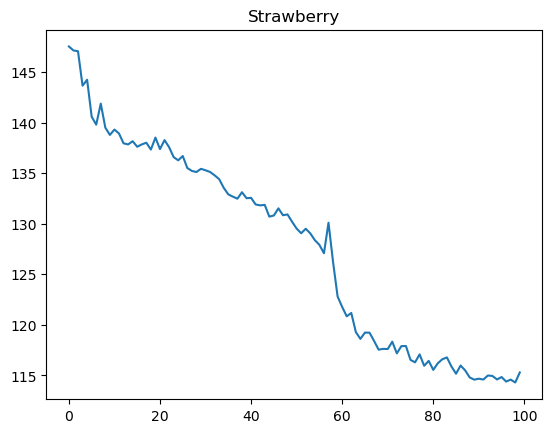

In [7]:
train()

100%|██████████| 19/19 [00:00<00:00, 191.16it/s]


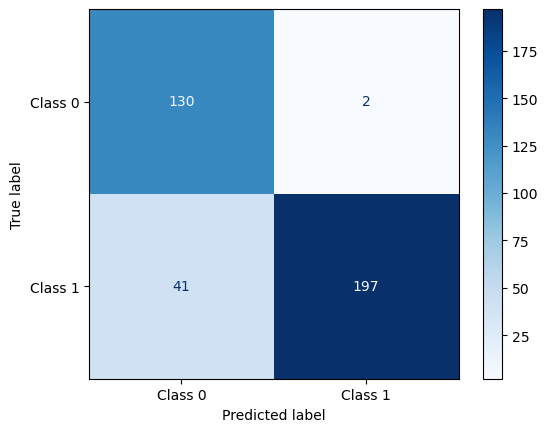

     Class  Accuracy
0  Class 0  0.984848
1  Class 1  0.827731
2    TOTAL  0.883784


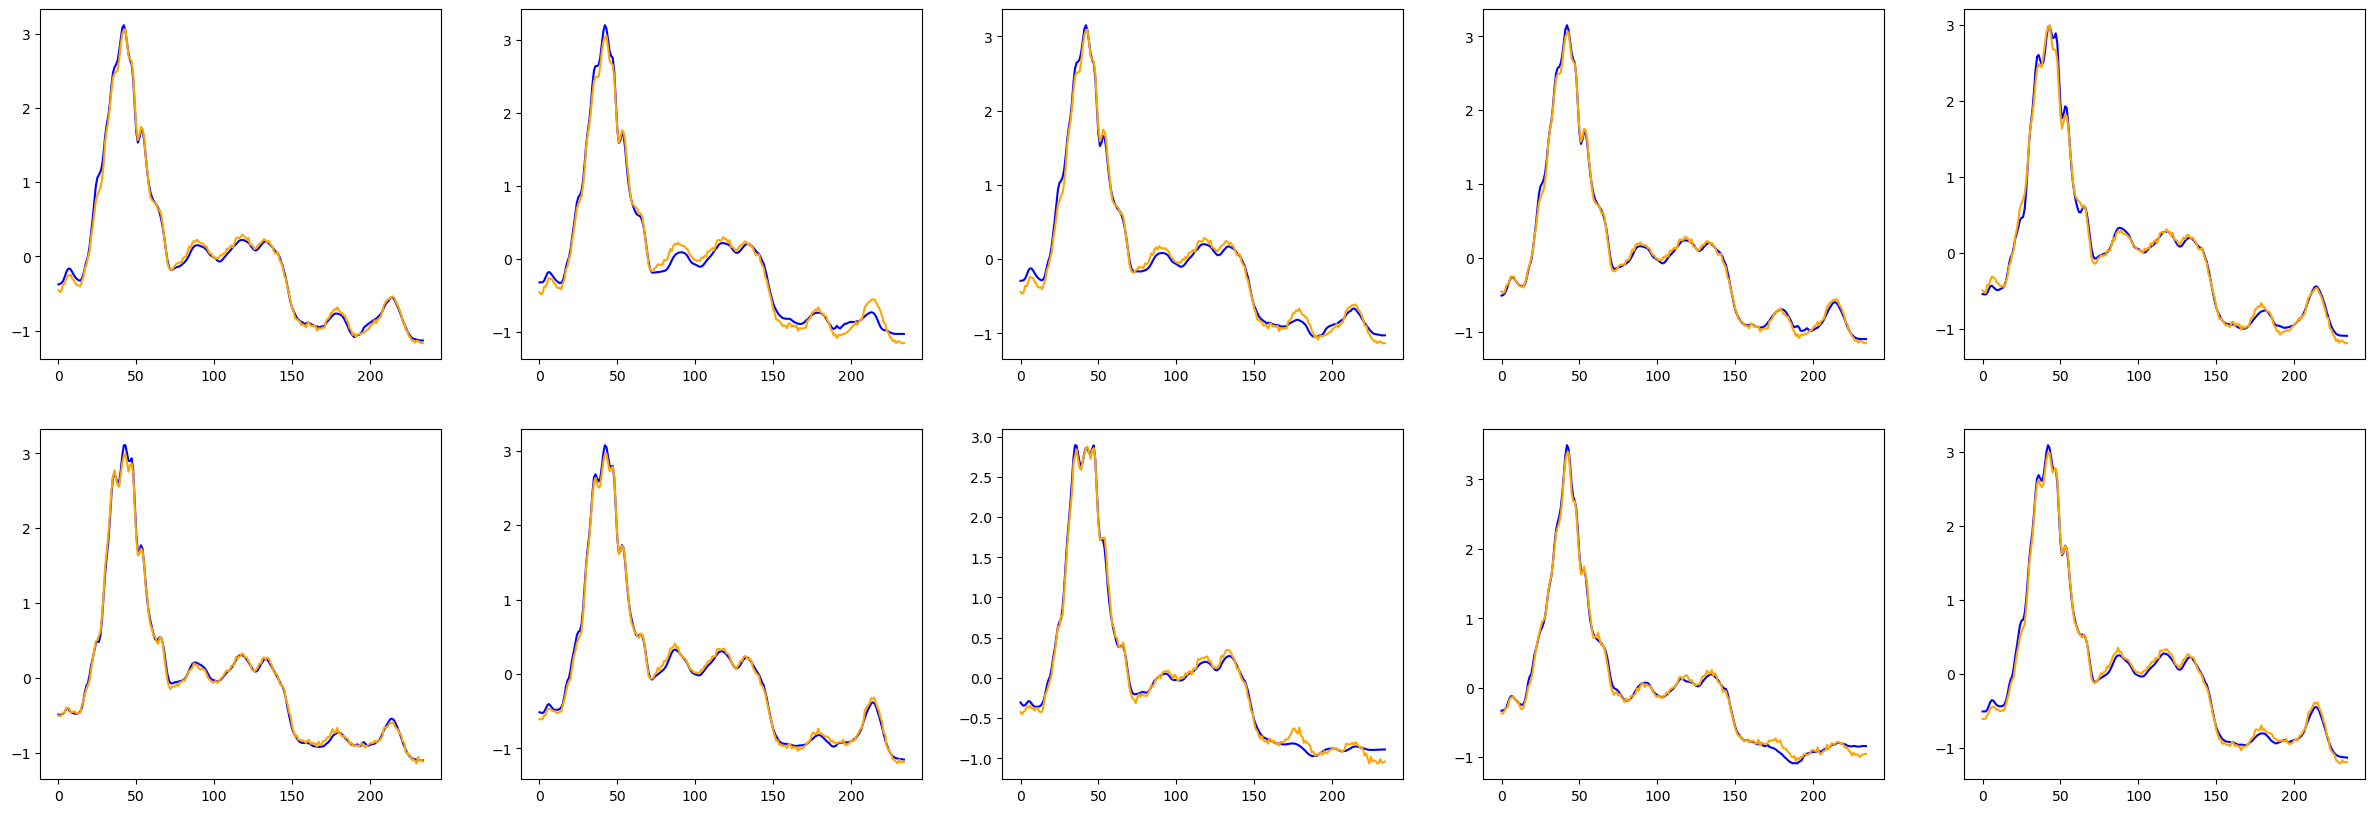

In [8]:
acc_chart = evaluate_and_reconstruct()
acc_chart